# Use POCA Ellipsoid info to match Tracks to Primary Vertices
_____
The goal of this notebook is to attempt to match tracks to primary vertices using the mean and widths of the POCA error ellipsoids

___
<span style="color: blue;">First, let's check to see which GPUs are currently being used:</span>

In [1]:
!nvidia-smi

Tue Jun 15 14:48:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   44C    P2    34W / 250W |   9497MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

___
<span style="color: blue;">Now, we can select which machine we want to use:</span>

In [3]:
from model.training import select_gpu
device = select_gpu(-1)

___
<span style="color: blue;">Here, we import everything we need. The ellipsoid functions imported from model.plots_mdsA_200518 are originally from the Towards_Ellipsoids_*.ipynb notebooks. The model used in this notebook is the four-feature, 6-layer CNN.</span>

In [4]:
#import libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')
import numpy as np
import torch
import h5py
import math as m
try:
    import awkward0 as awkward
except ModuleNotFoundError:
    import awkward
concatenate = awkward.concatenate
from matplotlib.patches import Ellipse
import sys
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

#local imports
from model.models_mds_F import FourFeature_CNN6Layer_D as Model
from model.collectdata_poca_KDE import collect_data_poca, collect_truth
from model.plots_emk_200518 import gaussian, collect_poca, plot_ruiplot
from model.efficiency_res_optimized import get_std_resolution
from model.efficiency import pv_locations, efficiency
from model.core import modernize

___
<span style="color: blue;">Now, we load our validation dataset, using the method imported from model.collectdata_poca_KDE. The validation set is created in slices of 500. Masking is set to True, and shuffle is set to False in order to retain the order of events. The device is set to that which we previously specified.</span>

In [5]:
#specify the path to the dataset (here, dataAA is a symlink to /share/lazy/sokoloff/ML-data_AA)
#file = '/share/lazy/sokoloff/ML-data_AA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5'
file = '/share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5'
validation = collect_data_poca(file,
                          batch_size=1,
                          slice=slice(1000),
                          masking=True, shuffle=False,
                          device=device,
                          load_XandXsq=True,
                          load_xy=True)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5 in 17.93 s
Constructing 1000 event dataset took 0.01288 s


In [6]:
pocas = collect_poca(file)

<KeysViewHDF5 ['Xmax', 'Ymax', 'kernel', 'major_axis_x', 'major_axis_y', 'major_axis_z', 'minor_axis1_x', 'minor_axis1_y', 'minor_axis1_z', 'minor_axis2_x', 'minor_axis2_y', 'minor_axis2_z', 'poca_KDE_A', 'poca_KDE_A_xMax', 'poca_KDE_A_yMax', 'poca_KDE_B', 'poca_KDE_B_xMax', 'poca_KDE_B_yMax', 'poca_x', 'poca_y', 'poca_z', 'pv', 'pv_cat', 'pv_loc', 'pv_loc_x', 'pv_loc_y', 'pv_ntracks', 'pv_other', 'recon_tx', 'recon_ty', 'recon_x', 'recon_y', 'recon_z', 'sv', 'sv_cat', 'sv_loc', 'sv_loc_x', 'sv_loc_y', 'sv_ntracks', 'sv_other']>


___
<span style="color: blue;">Now we load the Xmax and Ymax arrays from the hdf5 file:</span>

In [6]:
with h5py.File(file, mode='r') as XY:
    #assign numpy arrays corresponding to xmax and ymax
    xmax = np.asarray(XY['Xmax'])
    ymax = np.asarray(XY['Ymax'])

___
<span style="color: blue;">Now we collect the truth information from the hdf5 file corresponding to the primary vertices (pvs = True) and print some examples.</span>

In [7]:
PV = collect_truth(file, pvs=True)
ind = 57
print('PV.n.shape =    ',  PV.n.shape)
print(f'PV.n[{ind}].shape = ', *PV.n[ind].shape)
print(f'PV.x[{ind}] =       ', *PV.x[ind])
print(f'PV.y[{ind}] =       ', *PV.y[ind])
print(f'PV.z[{ind}] =       ', *PV.z[ind])
print(f'PV.n[{ind}] =       ', *PV.n[ind])
print(f'PV.cat[{ind}] =     ', *PV.cat[ind])

Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5 in 0.02255 s
PV.n.shape =     (51349,)
PV.n[57].shape =  9
PV.x[57] =        0.0273 -0.0092 0.0773 0.0203 0.004 -0.0198 0.014 -0.0213 -0.0003
PV.y[57] =        0.043 -0.0092 -0.0256 0.01 -0.0131 0.0027 -0.0218 0.0193 -0.0104
PV.z[57] =        -12.7585 37.5301 -62.4376 8.3657 76.444 -70.5117 -93.2232 21.7917 -43.4719
PV.n[57] =        24 0 14 69 0 70 14 0 98
PV.cat[57] =      1 -1 1 1 -1 1 1 -1 1


___
<span style="color: blue;">We repeat the process for secondary vertices:</span>

In [8]:
SV = collect_truth(file, pvs=False)
ind = 57
print('SV.n.shape =    ', SV.n.shape)
print(f'SV.n[{ind}].shape = ', *SV.n[ind].shape)
print(f'SV.x[{ind}] =       ', *SV.x[ind])
print(f'SV.y[{ind}] =       ', *SV.y[ind])
print(f'SV.z[{ind}] =       ', *SV.z[ind])
print(f'SV.n[{ind}] =       ', *SV.n[ind])
print(f'SV.cat[{ind}] =     ', *SV.cat[ind])

Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5 in 0.2017 s
SV.n.shape =     (51349,)
SV.n[57].shape =  191
SV.x[57] =        0.0273 0.0273 0.0273 0.0273 0.0273 0.0273 0.0273 0.0686 0.0686 0.0273 0.0273 0.0273 0.0273 0.0273 0.0273 0.0773 0.0773 0.0773 0.0773 0.0773 0.0773 0.0773 0.0773 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 0.0203 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 -0.0198 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 0.014 -0.0003 -0.0003 -0.0003 -0.0003 -0.7885 -0.0003 -0.0003 -0.0003 -0.0003 -0.0003 -0.0003 -0.0003 -0.0003 -0.0003 -0.0003 -0.0003 -0.

___
<span style="color: blue;">Now we need to load the model:</span>

In [13]:
#specify name of trained model
name = '/share/lazy/sokoloff/ML/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5_final.pyt'
model = Model().to(device)
d = torch.load(name, map_location=torch.device('cpu'))
d = modernize(d, 3)

#load and evaluate model
model.load_state_dict(d)
model.eval()

FourFeature_CNN6Layer_D(
  (conv1): Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4of6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5of6): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (ppFc1): Linear(in_features=4000, out_features=4000, bias=True)
  (ppFinalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropou

___
<span style="color: blue;">Create numpy arrays corresponding to the outputs and labels of the model:</span>

In [14]:
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()

___
<span style="color: blue;">Create numpy array corresponding to the test dataset:</span>

In [15]:
test = validation.dataset.tensors[0].cpu().numpy()
print('test.shape = ',test.shape)

test.shape =  (1000, 4, 4000)


In [16]:
print(PV.x[0])
print(PV.y[0])

[-0.0396  0.0155  0.0043 -0.0027  0.0548  0.0204 -0.0377 -0.0384 -0.0188
  0.0136 -0.0047]
[ 0.0095 -0.0427  0.005  -0.0105 -0.0134  0.0126  0.07   -0.0068  0.0239
 -0.0223 -0.0323]


___
<span style="color: blue;">Finally, we can create our plots:</span>

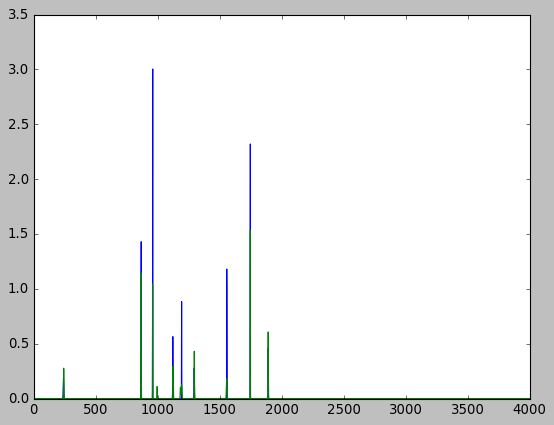

In [29]:
inputs = validation.dataset.tensors[0].cpu().numpy()[:,0,:]
zvals = np.linspace(-100, 300, 4000, endpoint=False) + 0.05
finalmsg = ''
internal_count = 0
output_filename = None # Or set: '120000_3layer_{number:02}.pdf'

min_z_vals = []
max_z_vals = []

ratios = np.zeros(test.shape[0])
stds = []
deltazmin_matched = []
deltazmin_unmatched = []

PV_colors = ['brown','red','orangered','orange','gold','olive','lawngreen','green',
             'springgreen','turquoise','cyan','deepskyblue','dodgerblue','navy','blue',
            'indigo','darkviolet','purple','magenta','deeppink']

for event in range(test.shape[0]):
    
    #assign current input, label, and output for event
    input = inputs[event]
    label = labels[event]
    output = outputs[event]
    
    plt.plot(np.arange(0,len(label),1),label)
    plt.plot(np.arange(0,len(output),1),output)
    plt.show()
    break
    
    # Consistent parameters for the calls below
    parameters = {
        "threshold": 1e-2,
        "integral_threshold": .2,
        "min_width": 3
    }
    
    # Compute the "actual" efficencies and things
    ftruth = pv_locations(label, **parameters)
    fcomputed = pv_locations(output, **parameters)
    results = efficiency(label, output, difference=5.0, **parameters)
    
    
    # Add a line to the final results string (print at end)
    #finalmsg += f"Event {event}: {results}\n"
    
    # Make sure bin numbers are integers
    truth = np.around(ftruth).astype(np.int32)
    computed = np.around(fcomputed).astype(np.int32)
    
    # Join arrays and remove any points closer than 5 bins
    # We plot over these "points of interest"
    #poi = np.sort(np.concatenate([truth, computed]))
    #poi = poi[np.concatenate([[True], np.fabs(np.diff(poi)) > 5])]
    
    print(f"\nEvent {event}:", results)
    
    #grab means of predicted PVs
    comp_centroids = (fcomputed / 10) - 100
    
    #find standard deviations of predicted PVs
    std = get_std_resolution(fcomputed, output, 3.5, 0.001, 20, 0)
    std = std/10
    #stds.append(std.tolist())
    
    n_matched = 0
    
    maxy = 0
    
    matches = {}
    for i in range(len(comp_centroids)):
        matches[i] = []
    
    minmatched = sys.float_info.max
    minunmatched = sys.float_info.max
    
    heights = np.zeros(len(pocas["z"]["poca"][event]))
    
    for j in range(len(pocas["z"]["poca"][event])):
        current_gauss = gaussian(zvals, pocas["z"]["poca"][event][j], pocas["z"]["major_axis"][event][j])
        heights[j] = max(current_gauss)
        if maxy<max(current_gauss):
            maxy = max(current_gauss)
        if not len(comp_centroids)==0:
            diff = np.abs(np.add(comp_centroids, -pocas["z"]["poca"][event][j]))
            minimum = diff.min()
            ind = np.where(diff == minimum)[0][0]
            std_mod = np.sqrt(pocas["z"]["major_axis"][event][j]**2 + std[ind]**2)
            stds.append(std_mod)
            if minimum <= 5*std_mod:
                plt.plot(zvals, current_gauss, color = PV_colors[ind])
                n_matched += 1
                matches[ind].append(j)
                if minimum <= minmatched:
                    minmatched = minimum
            else:
                plt.plot(zvals, current_gauss, color = 'k')
                if minimum <= minunmatched:
                    minunmatched = minimum
        else:
            plt.plot(zvals, current_gauss, color = 'k')
    
    print("Percentage Matched = ", 100*n_matched/len(pocas["z"]["poca"][event]), "%")
    
    ratios[event] = n_matched/len(pocas["z"]["poca"][event])
    deltazmin_matched.append(minmatched)
    deltazmin_unmatched.append(minunmatched)
    
    for j in range(len(comp_centroids)):
        plt.plot(comp_centroids[j], np.ones_like(comp_centroids[j])*.4, 'o', color= PV_colors[j], markeredgecolor = 'k')

    plt.xlim([zvals[0],zvals[-1]])
    plt.ylim([0,1.2*maxy])
    plt.show()
    
    x_guesses = np.zeros(len(comp_centroids))
    y_guesses = np.zeros(len(comp_centroids))
    for i in matches:
        x_guesses[i] = np.average([pocas["x"]["poca"][event][j] for j in matches[i]], 
                                  weights = [heights[j] for j in matches[i]])
        y_guesses[i] = np.average([pocas["y"]["poca"][event][j] for j in matches[i]], 
                                  weights = [heights[j] for j in matches[i]])
    
    true_z_values = pv_locations(label, , integral_threshold, min_width)
    
    plt.plot(x_guesses, y_guesses, 'o', color = 'g', label = "from POCA")
    plt.plot(PV.x[event], PV.y[event], 'o', color = 'b', label = "truth")
    plt.legend()
    title = f"\nEvent {event}:" + str(results)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
            
    print(PV.x[event])
    print(PV.y[event])
    print(PV.z[event])



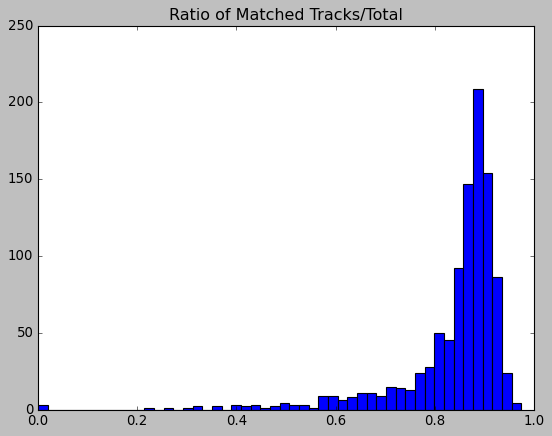

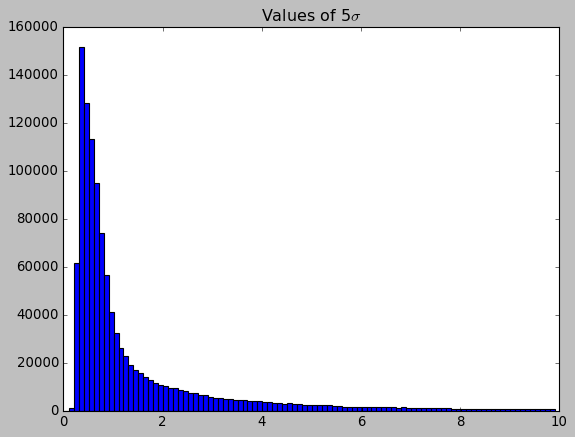

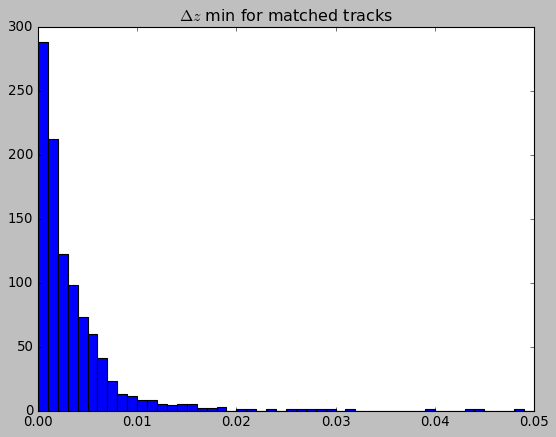

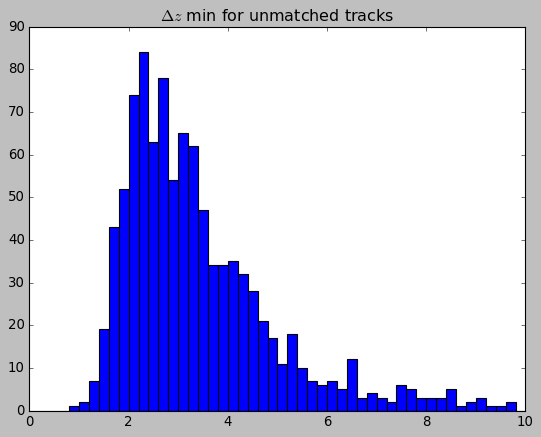

In [17]:
plt.hist(ratios, bins=50)
plt.title("Ratio of Matched Tracks/Total")
plt.show()

sbins = np.arange(0.01,10.01,0.1)
plt.hist(5*stds, bins=sbins)
plt.title("Values of 5$\sigma$")
plt.show()

plt.hist(deltazmin_matched, bins=50, range=[0,0.05])
plt.title("$\Delta z$ min for matched tracks")
plt.show()

plt.hist(deltazmin_unmatched, bins=50, range=[0,10])
plt.title("$\Delta z$ min for unmatched tracks")
plt.show()

In [15]:
print(stds[0:100])

[2.0236856931834684, 11.24487746740432, 30.767137315768913, 12.250662519760118, 6.157966526713522, 13.340508198465345, 17.663174937634505, 6.863405266227667, 4.889384479341581, 6.399411549390722, 6.047369176003828, 5.177657918310718, 6.648726751728273, 3.6670764828302533, 2.6830819338562764, 2.592305737571479, 3.5211436550802806, 2.3206288342259613, 3.5071229019967234, 5.370287467527858, 3.434886010418169, 2.6602874017325884, 3.761138948479269, 2.994910357668972, 1.9881623125347554, 1.3724733988907807, 2.5045326835720774, 2.29570358292586, 2.426266098450687, 2.8779150136067297, 0.6785412066866343, 1.549857103368402, 5.433702214034025, 1.6855203954297153, 2.234765244711497, 2.223146348140721, 1.2533305064839626, 2.376045006417435, 2.289669978884936, 1.72786799843498, 2.613199115711013, 1.3153639864133084, 0.47008163725623076, 0.5525724810618219, 0.6760134045646573, 4.21843898969524, 1.3550844467224605, 2.1115246471184177, 1.0792778003443728, 1.4039110057105697, 1.1933367870805007, 1.455